In [1]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.

drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [0]:
import zipfile
zip_ref = zipfile.ZipFile('/content/drive/My Drive/Skeleton.zip', 'r')
zip_ref.extractall('./')
zip_ref.close()

In [0]:
import scipy.io
import numpy as np
import pandas as pd

from pathlib import Path
from matplotlib import pyplot as plt
import operator

In [0]:
#https://github.com/woo-chia-wei/kinect-sequence-classification
def import_skeleton_data(action, subject, trial):
    filename = f'Skeleton/a{action}_s{subject}_t{trial}_skeleton.mat'
    #print(Path(filename).is_file())
    #if Path(filename).is_file():
    mat = scipy.io.loadmat(filename)
    return mat['d_skel']
  #  else:
  #      return None

def transform_skeleton_data(action, subject, trial):
    matrices = []
    data = import_skeleton_data(action, subject, trial)
    #print(data.shape)
    if data is None: return None
    #print(data[:,0,0])
    for frame in range(data.shape[2]):
        skelecton_joints = [i + 1 for i in range(20)]
        matrix = data[:,:,frame]
        matrix = np.insert(matrix, 0, skelecton_joints, axis=1)
        matrix = np.insert(matrix, 0, frame, axis=1)
        matrices.append(matrix)
    result = np.vstack(tuple(matrices))
    result = np.insert(result, 0, [[action], [subject], [trial]], axis=1)
    #print(result)
    return result

def transform_skeleton_data_to_df(action, subject, trial):
    data = transform_skeleton_data(action, subject, trial)
    #print(data.shape)
    if data is None: return None
    df = pd.DataFrame(data)
    df.columns = ['action', 'subject', 'trial', 'frame', 'skeleton_joint', 'x', 'y', 'z']
    return df



In [0]:
data_columns = ['head','shoulder_center', 'spine','hip_center' ,'left_shoulder','left_elbow','left_wrist','left_hand','right_shoulder','right_elbow','right_wrist','right_hand','left_hip',
              'left_knee','left_ankle','left_foot','right_hip','right_knee','right_ankle','right_foot' ]
columns = data_columns + ['action']

In [0]:
def change_data(frame):
    keys = np.array(frame['skeleton_joint'])
    joint = 1
    dfx = pd.DataFrame(columns = columns)
    dfy = pd.DataFrame(columns = columns)
    dfz = pd.DataFrame(columns = columns)
    dfx['action'] = frame['action']
    dfy['action'] = frame['action']
    dfz['action'] = frame['action']
    for i in range(len(data_columns)):
       
        #print(i)
        dfx[data_columns[i]] = np.array(frame.x)* np.where(keys ==joint, keys, 0)
        #print(i)
        
        dfy[data_columns[i]] = np.array(frame.y)* np.where(keys ==joint, keys, 0)

        
        dfz[data_columns[i]] = np.array(frame.z)* np.where(keys ==joint, keys, 0)
        joint += 1
   
    return dfx, dfy, dfz

In [0]:
subjects_x = []
subjects_y = []
subjects_z = []
for a in range(1,28):
    for s in range(1,9):
        for t in range(1,5):
            try:
                df = transform_skeleton_data_to_df(a, s, t)
                #print(len(df))
                dfx, dfy, dfz = change_data(df)
                subjects_x.append(dfx)
                subjects_y.append(dfy)
                subjects_z.append(dfz)
            except FileNotFoundError:
                pass

In [0]:
def reduce(list_of_df):
    new_subjects = []
    for df in list_of_df:
        assert(len(df.action.unique()) == 1)


        new = pd.DataFrame(columns = list(df))

        for col in list(df):
            if col != 'action':
                dat = np.array(df[col])
                dat = dat[dat != 0.]
                new[col] = dat
        new['action'] = df.action.unique()[0]
        new_subjects.append(new)
    return new_subjects

In [0]:
list_x = reduce(subjects_x)
list_y = reduce(subjects_y)
list_z = reduce(subjects_z)

In [0]:

cat_np = []
targets = np.array([])
for i in range(len(list_x)):
    df = list_x[i].append(list_y[i], ignore_index =True)
    df = df.append(list_z[i], ignore_index = True)
    assert(len(df.action.unique()) == 1)
    targets = np.append(targets, df.action.unique()[0])
    df = df.drop(['action'], axis=1)
    cat_np.append(df.T.to_numpy())
    

In [0]:
max_frames = 0
min_frames = 400
ave = 0
for i in range(len(cat_np)):
    t = cat_np[i].shape[1]
    if t > max_frames:
        max_frames = t
    if t < min_frames:
        min_frames = t
    ave += t
ave = ave / len(cat_np)

In [12]:
max_frames, min_frames, ave

(375, 123, 203.13240418118468)

In [0]:
transformed_data = []
for video in cat_np:
    
    if video.shape[1] > 201:
        video = video[:, :201]
    
    c_min = np.amin(video, axis=1, keepdims=True)
    c_max = np.amax(video, axis=1, keepdims=True)
    max_k = np.amax(c_max - c_min)
    P = np.floor(255. * (video - c_min) / max_k)
    #print( max_k)
    if P.shape[1] < 201:
        zeros = np.zeros((P.shape[0], 201- P.shape[1]))
        P = np.hstack((P, zeros))
    transformed_data.append(P)

In [0]:
targets -= 1

In [0]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#from google.colab import files
import torch.nn as nn
import torch
import torchvision
import os
import torch.optim as optim
import torchvision.transforms as transforms

from torch.autograd import Variable

import math

In [0]:

import torch.utils.data
from sklearn.model_selection import train_test_split
import torch

class Dataset(torch.utils.data.Dataset):
  
    def __init__(self, data, targets, fold='train'):
        self.fold = fold
      
        

        X_train, X_, y_train, y_ = train_test_split( data, targets, train_size=0.7, random_state=42)
        X_val, X_test, y_val, y_test = train_test_split(X_, y_, train_size=0.6, random_state=42)
        self.train_data = torch.FloatTensor(X_train)
        self.train_labels = torch.LongTensor(y_train)
        
        self.val_data = torch.FloatTensor(X_val)
        self.val_labels = torch.LongTensor(y_val)
        self.test_data = torch.FloatTensor(X_test)
        self.test_labels = torch.LongTensor(y_test)
      
    def __len__(self):
        if self.fold == 'train':
            return len(self.train_data)
        elif self.fold == 'val':
            return len(self.val_data)
        elif self.fold == 'test':
            return len(self.test_data)
     
            
  

    def __getitem__(self, index):
      
        if self.fold == 'train':
            data = self.train_data[index]
            label =  self.train_labels[index]
        elif self.fold == 'val':
            data = self.val_data[index]
            label =  self.val_labels[index]
        elif self.fold == 'test':
            data = self.test_data[index]
            label =  self.test_labels[index]
        return data,label

In [0]:
train_dataset = Dataset(transformed_data, targets,fold='train')

In [0]:
val_dataset = Dataset(transformed_data, targets,fold='val')
test_dataset = Dataset(transformed_data, targets,fold='test')

In [0]:
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=50,shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset,batch_size=20,shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=20,shuffle=False)

In [0]:
import torchvision.models as models


In [21]:
#https://colab.research.google.com/github/pytorch/tutorials/blob/gh-pages/_downloads/finetuning_torchvision_models_tutorial.ipynb#scrollTo=XVeRWfblXYOY
from __future__ import print_function 
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.1.0
Torchvision Version:  0.3.0


In [0]:
# Number of classes in the dataset
num_classes = 27

# Batch size for training (change depending on how much memory you have)
batch_size = 50

# Number of epochs to train for 
num_epochs = 15

# Flag for feature extracting. When False, we finetune the whole model, 
#   when True we only update the reshaped layer params
feature_extract = False

In [0]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                #inputs = inputs.to(device)
                labels = labels.to(device)
                """
                inputs = torch.transpose(inputs, 1, 2)
                inputs = nn.Linear(20,3)(inputs)
                inputs = torch.transpose(inputs, 1, 2)
                inputs = inputs.unsqueeze(3)\
                """
                #print(inputs.shape)
                try:
                    inputs = inputs.view(50, 3, 20, 67)
                except RuntimeError:
                    inputs = inputs.view(-1, 3, 20, 67)
                inputs = inputs.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [0]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [0]:
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=50,shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset,batch_size=50,shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=50,shuffle=False)

In [26]:
def initialize_model( model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes) 
        input_size = 224

    elif model_name == "inception":
        """ Inception v3 
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()
    
    return model_ft, input_size

# Initialize the model for this run

model_ft = None
model_name ="resnet"
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [27]:

# Send the model to GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are 
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.0004, momentum=0.9)

Params to learn:
	 conv1.weight
	 bn1.weight
	 bn1.bias
	 layer1.0.conv1.weight
	 layer1.0.bn1.weight
	 layer1.0.bn1.bias
	 layer1.0.conv2.weight
	 layer1.0.bn2.weight
	 layer1.0.bn2.bias
	 layer1.1.conv1.weight
	 layer1.1.bn1.weight
	 layer1.1.bn1.bias
	 layer1.1.conv2.weight
	 layer1.1.bn2.weight
	 layer1.1.bn2.bias
	 layer2.0.conv1.weight
	 layer2.0.bn1.weight
	 layer2.0.bn1.bias
	 layer2.0.conv2.weight
	 layer2.0.bn2.weight
	 layer2.0.bn2.bias
	 layer2.0.downsample.0.weight
	 layer2.0.downsample.1.weight
	 layer2.0.downsample.1.bias
	 layer2.1.conv1.weight
	 layer2.1.bn1.weight
	 layer2.1.bn1.bias
	 layer2.1.conv2.weight
	 layer2.1.bn2.weight
	 layer2.1.bn2.bias
	 layer3.0.conv1.weight
	 layer3.0.bn1.weight
	 layer3.0.bn1.bias
	 layer3.0.conv2.weight
	 layer3.0.bn2.weight
	 layer3.0.bn2.bias
	 layer3.0.downsample.0.weight
	 layer3.0.downsample.1.weight
	 layer3.0.downsample.1.bias
	 layer3.1.conv1.weight
	 layer3.1.bn1.weight
	 layer3.1.bn1.bias
	 layer3.1.conv2.weight
	 layer3.1.b

In [28]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()


# Train and evaluate

model_ft, hist = train_model(model_ft, {'train':train_loader, 'val':val_loader, 'test':test_loader}, criterion, optimizer_ft, num_epochs=500, is_inception=(model_name=="inception"))

Epoch 0/499
----------
train Loss: 3.5894 Acc: 0.0266
val Loss: 3.5031 Acc: 0.0258

Epoch 1/499
----------
train Loss: 3.1230 Acc: 0.1329
val Loss: 3.2620 Acc: 0.0968

Epoch 2/499
----------
train Loss: 2.7039 Acc: 0.2458
val Loss: 2.9235 Acc: 0.2129

Epoch 3/499
----------
train Loss: 2.3583 Acc: 0.3771
val Loss: 2.5155 Acc: 0.2516

Epoch 4/499
----------
train Loss: 2.0579 Acc: 0.4551
val Loss: 2.3940 Acc: 0.3742

Epoch 5/499
----------
train Loss: 1.8838 Acc: 0.5249
val Loss: 2.1716 Acc: 0.4129

Epoch 6/499
----------
train Loss: 1.6658 Acc: 0.5930
val Loss: 2.0255 Acc: 0.4710

Epoch 7/499
----------
train Loss: 1.4537 Acc: 0.6478
val Loss: 1.9736 Acc: 0.4516

Epoch 8/499
----------
train Loss: 1.3315 Acc: 0.6744
val Loss: 1.7663 Acc: 0.5226

Epoch 9/499
----------
train Loss: 1.1467 Acc: 0.7292
val Loss: 1.6338 Acc: 0.4903

Epoch 10/499
----------
train Loss: 1.0464 Acc: 0.7458
val Loss: 1.7876 Acc: 0.4903

Epoch 11/499
----------
train Loss: 0.9442 Acc: 0.7857
val Loss: 1.5998 Acc

In [29]:
model_ft.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (conv2): Co

In [0]:
torch.save(model_ft.state_dict(), "/content/drive/My Drive/models/saved_resnet_final.pth")

In [0]:
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=len(test_dataset),shuffle=False)

In [0]:
for batch in test_loader:
    
    data,reference = batch
    data = data.view(104, 3, 20, 67)
    """
    #data = data.unsqueeze(3)
    data = torch.transpose(data, 1, 2)
    data = nn.Linear(20, 3)(data)
    #data = nn.Linear(1,3)(data)
    data = torch.transpose(data, 0, 2)
    #data = torch.transpose(data, 1, 3)
    data = data.unsqueeze(0)
    data = torch.transpose(data, 0, 3)
    
    #print(data.shape)
    """
    #data = nn.Linear(25,100)(data)
    #data = data.view(104, 3, 100, 25)
    #data = data.unsqueeze(3)
    #data = nn.Linear(1,3)(data)
    """
    data = torch.transpose(data, 1, 2)
    data = nn.Linear(20,3)(data)
    data = torch.transpose(data, 1, 2)
    data = data.unsqueeze(3)
    """
    data = data.to(device)
    predictions = model_ft(data)
    

Validation accuracy 0.7935483870967742
Test_accuracy 0.7788461446762085


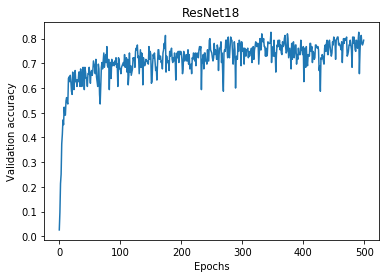

In [33]:
plt.plot(hist)
plt.xlabel('Epochs')
plt.ylabel('Validation accuracy')
plt.title('ResNet18')
print('Validation accuracy '+str(hist[-1].item()))
predictions = torch.argmax(predictions.type(torch.float32).log_softmax(dim=-1),dim=-1).cpu()
acc = (reference == predictions).to(torch.float32).mean()
print('Test_accuracy '+str(acc.item()))

Validation accuracy 0.7935483870967742
Test_accuracy 0.0


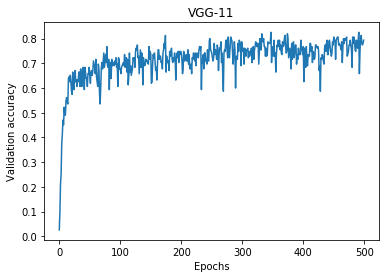

In [34]:
plt.plot(hist)
plt.xlabel('Epochs')
plt.ylabel('Validation accuracy')
plt.title('VGG-11')
print('Validation accuracy '+str(hist[-1].item()))
predictions = torch.argmax(predictions.type(torch.float32).log_softmax(dim=-1),dim=-1).cpu()
acc = (reference == predictions).to(torch.float32).mean()
print('Test_accuracy '+str(acc.item()))

Validation accuracy 0.7935483870967742
Test_accuracy 0.028846153989434242


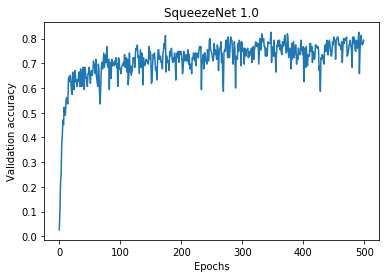

In [35]:
plt.plot(hist)
plt.xlabel('Epochs')
plt.ylabel('Validation accuracy')
plt.title('SqueezeNet 1.0')
print('Validation accuracy '+str(hist[-1].item()))
predictions = torch.argmax(predictions.type(torch.float32).log_softmax(dim=-1),dim=-1).cpu()
acc = (reference == predictions).to(torch.float32).mean()
print('Test_accuracy '+str(acc.item()))

Validation accuracy 0.7935483870967742
Test_accuracy 0.028846153989434242


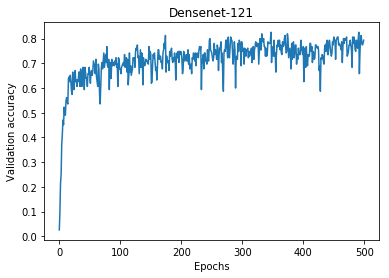

In [36]:
plt.plot(hist)
plt.xlabel('Epochs')
plt.ylabel('Validation accuracy')
plt.title('Densenet-121')
print('Validation accuracy '+str(hist[-1].item()))
predictions = torch.argmax(predictions.type(torch.float32).log_softmax(dim=-1),dim=-1).cpu()
acc = (reference == predictions).to(torch.float32).mean()
print('Test_accuracy '+str(acc.item()))

In [0]:
file_path = "/content/drive/My Drive/Colab Notebooks/Sergey/pickup/Joint_Position.binary"

In [56]:
fid = np.fromfile(file_path, dtype=np.float32) 
jointNumber = 20
tracks = 6
Skeleton = np.reshape(fid, (-1, tracks, jointNumber,4))
for i in range(len(Skeleton[0])):
    for j in range(tracks):
        if Skeleton[0][i][j][0] != 0:
            client = i
            break

new_cord = []
print(len(Skeleton))
# print(Skeleton[1])
for j in range(jointNumber):
  for cord in range(3):
    for i in range(int(len(Skeleton)/6)):

      new_cord.append(Skeleton[i][client][j][cord])
      

# result = pd.DataFrame.from_records(new_cord, columns=columns)      

135


In [0]:
x = np.asarray(new_cord)
x = np.reshape(x,(20,-1))
hip_center = x[0]
spine = x[1]
shoulder_center = x[2]
head = x[3]

x[0] = head
x[1] = shoulder_center
x[2] = spine
x[3] = hip_center

max_frames = 0
min_frames = 400
ave = 0

t = x.shape[1]
if t > max_frames:
    max_frames = t
if t < min_frames:
    min_frames = t
ave += t
ave = ave / len(x)

transformed_data = []

    
if x.shape[1] > 201:
    x = x[:, :201]

c_min = np.amin(x, axis=1, keepdims=True)
c_max = np.amax(x, axis=1, keepdims=True)
max_k = np.amax(c_max - c_min)
P = np.floor(255. * (x - c_min) / max_k)
#print( max_k)
if P.shape[1] < 201:
    zeros = np.zeros((P.shape[0], 201- P.shape[1]))
    P = np.hstack((P, zeros))
transformed_data.append(P)

In [0]:
activities = ['right arm swipe to the left', 'right arm swipe to the right', 'right hand wave', 'two hand front clap', 'right arm throw', 'cross arms in the chest', 'basketball shoot',
              'right hand draw x', 'right hand draw circle (clockwise)', 'right hand draw circle (counter clockwise)', 'draw triangle', 'bowling (right hand)', 'front boxing', 
              'baseball swing from right', 'tennis right hand forehand swing', 'arm curl (two arms)', 'tennis serve', 'two hand push', 'right hand knock on door', 
              'right hand catch an object', 'right hand pick up and throw', 'jogging in place', 'walking in place', 'sit to stand', 'stand to sit', 'forward lunge (left foot forward)',
              'squat (two arms stretch out)']


  

In [0]:
def prediction_read(transformed_data, model):
  data_x = torch.FloatTensor(transformed_data)

  data_y = data_x.view(-1, 3, 20, 67)
  data_y = data_y.to(device)
  y_pred = model(data_y)
  res_y = y_pred.cpu().data.numpy()
  x = dict(zip(activities,res_y[0]))
  y = sorted(x.items(), key=operator.itemgetter(1), reverse=True)
  return y[:3]

In [60]:
prediction_read(transformed_data, model_ft)

[('sit to stand', 5.4009886),
 ('tennis right hand forehand swing', 2.954891),
 ('right hand wave', 2.7974744)]